# Train Low Test Models

This notebook is a streamlined notebook for generating minima of low test accuracy through three different means:
- Dataset Poisoning
- Adding Noise to Data
- Decreasing Dataset Sizes

## Imports

In [1]:
# Standard library
import copy
import os
import sys
import time

# Third-party
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

# Local package imports
from minima_volume.dataset_funcs import (
    prepare_datasets,
    save_dataset,
    save_model,
)
from minima_volume.train_funcs import evaluate, train

device = torch.device("cuda" if torch.cuda.is_available() else "mps")

## Input Parameters

In [2]:

# ==============================
# Base Input Parameters
# ==============================
# --- SEEDS ---
data_seed = 10            
model_seed = 28           

# --- Training configuration ---
epochs = 100       

# --- Dataset configuration ---
base_data_size = 1000
dataset_type = "data"   
dataset_quantities = [0, 100, 200, 500, 1000, 2000, 5000, 10000]

# --- Output configuration ---
base_output_dir = ""     
save_generated_dataset = True   
save_generated_models = True    


## Model + Dataset Specific Code

This is for specific code.

In [3]:
# User specifies the model module name
from minima_volume.models import MNIST_model_data as model_module

# Generate dataset
x_base, y_base, x_test, y_test = model_module.get_dataset(
    device = device
)

# MNIST specific initialization parameters
hidden_dims = [256, 128]

# Grab model
model_template = model_module.get_model(hidden_dims=hidden_dims, device=device, seed=model_seed)

# Grab loss and metrics
loss_fn = model_module.get_loss_fn()
other_metrics = model_module.get_additional_metrics()

## Training

We generate the various datasets used to train our models here, before training them. We record the losses, and what each model was trained on.

In [4]:
# ==============================
# Prepare datasets
# ==============================
x_base_train, y_base_train, x_additional, y_additional = prepare_datasets(
    x_base=x_base,
    y_base=y_base,
    dataset_type=dataset_type,
    dataset_quantities=dataset_quantities,
    base_data_size=base_data_size,
    data_seed=data_seed,
    seed_1=None,
    seed_2=None,
)

x_base_train = x_base_train.to(device)
y_base_train = y_base_train.to(device)
x_additional = x_additional.to(device)
y_additional = y_additional.to(device)
x_test = x_test.to(device)
y_test = y_test.to(device)

# ==============================
# Training loop
# ==============================
all_models = []

for additional_data in dataset_quantities:
    # Assemble training dataset
    x_train = torch.cat([x_base_train, x_additional[:additional_data]], dim=0)
    y_train = torch.cat([y_base_train, y_additional[:additional_data]], dim=0)

    # Initialize model (defined in the model-specific file)
    torch.manual_seed(model_seed)
    model = copy.deepcopy(model_template)
    optimizer = optim.AdamW(model.parameters(), lr=1e-3)
    batch_size = len(x_train)

    # Train model
    train_loss, train_other_metrics, test_loss, test_other_metrics = train(
        model = model,
        x_train = x_train, y_train = y_train,
        x_test = x_test, y_test = y_test,
        loss_fn = loss_fn,
        metrics = other_metrics,
        optimizer = optimizer,
        epochs=epochs,
        batch_size=batch_size,
        verbose_every=100,
    )
    
    # Build dictionary dynamically for additional metrics
    train_metrics_dict = {}
    test_metrics_dict = {}
    if train_other_metrics is not None:
        # train_other_metrics is a list of dicts per epoch
        for metric_name in train_other_metrics[0].keys():  # keys from first epoch
            train_metrics_dict[f"train_{metric_name}"] = [m[metric_name] for m in train_other_metrics]
            test_metrics_dict[f"test_{metric_name}"] = [m[metric_name] for m in test_other_metrics]
    
    # Store results
    trained_model = {
        "model": model,
        "train_loss": train_loss,
        "test_loss": test_loss,
        "additional_data": additional_data,
        "dataset_type": dataset_type,
        **train_metrics_dict,  # dynamically include additional metrics
        **test_metrics_dict,
    }
    
    all_models.append(trained_model)

    print(f"Completed training with {additional_data} additional samples of {dataset_type}")

    # Free memory (important for large GPU datasets)
    del x_train, y_train
    torch.cuda.empty_cache()


Epoch 1/100: Train Loss 2.3198 | Test Loss 2.1791 | accs Train 0.0970 Test 0.3574


Epoch 100/100: Train Loss 0.0025 | Test Loss 0.5436 | accs Train 1.0000 Test 0.8862
Completed training with 0 additional samples of data
Epoch 1/100: Train Loss 2.3196 | Test Loss 2.1795 | accs Train 0.0982 Test 0.3633


Epoch 100/100: Train Loss 0.0029 | Test Loss 0.5142 | accs Train 1.0000 Test 0.8905
Completed training with 100 additional samples of data
Epoch 1/100: Train Loss 2.3201 | Test Loss 2.1795 | accs Train 0.0958 Test 0.3739


Epoch 100/100: Train Loss 0.0034 | Test Loss 0.4971 | accs Train 1.0000 Test 0.8935
Completed training with 200 additional samples of data
Epoch 1/100: Train Loss 2.3199 | Test Loss 2.1774 | accs Train 0.0953 Test 0.3765


Epoch 100/100: Train Loss 0.0039 | Test Loss 0.4857 | accs Train 1.0000 Test 0.8962
Completed training with 500 additional samples of data
Epoch 1/100: Train Loss 2.3164 | Test Loss 2.1729 | accs Train 0.1030 Test 0.3564


Epoch 100/100: Train Loss 0.0060 | Test Loss 0.4123 | accs Train 1.0000 Test 0.9065
Completed training with 1000 additional samples of data
Epoch 1/100: Train Loss 2.3162 | Test Loss 2.1737 | accs Train 0.1053 Test 0.3449


Epoch 100/100: Train Loss 0.0125 | Test Loss 0.3350 | accs Train 1.0000 Test 0.9196
Completed training with 2000 additional samples of data
Epoch 1/100: Train Loss 2.3149 | Test Loss 2.1716 | accs Train 0.1112 Test 0.3507


Epoch 100/100: Train Loss 0.0352 | Test Loss 0.2229 | accs Train 0.9960 Test 0.9371
Completed training with 5000 additional samples of data
Epoch 1/100: Train Loss 2.3140 | Test Loss 2.1703 | accs Train 0.1173 Test 0.3354


Epoch 100/100: Train Loss 0.0721 | Test Loss 0.1739 | accs Train 0.9830 Test 0.9508
Completed training with 10000 additional samples of data


## Training Summary

In [5]:
# ====================================
# Summary of Training Results
# ====================================
print("=== True Generalization ===")
for model_data in all_models:
    model = model_data["model"]
    additional_data = model_data["additional_data"]

    test_loss, test_metrics = evaluate(
        model=model,
        x_test=x_test,
        y_test=y_test,
        loss_fn=loss_fn,
        metrics=other_metrics
    )

    metrics_str = " | ".join([f"{name}: {val:.4f}" for name, val in test_metrics.items()])
    print(
        f"{additional_data:>4} samples | "
        f"Test Loss: {test_loss:.4f}" + (f" | {metrics_str}" if metrics_str else "")
    )

print("\n=== Model Diagnostics by Training Data ===")
for additional_data in dataset_quantities:
    # Build dataset with this many additional samples
    x_train = torch.cat([x_base_train, x_additional[:additional_data]], dim=0)
    y_train = torch.cat([y_base_train, y_additional[:additional_data]], dim=0)

    print(f"\nDataset type: {dataset_type}, additional samples: {additional_data}")

    for model_data in all_models:
        model = model_data["model"]
        model_additional_data = model_data["additional_data"]

        train_loss, train_metrics = evaluate(
            model=model,
            x_test=x_train,
            y_test=y_train,
            loss_fn=loss_fn,
            metrics=other_metrics
        )

        metrics_str = " | ".join([f"{name}: {val:.4f}" for name, val in train_metrics.items()])
        print(
            f" Model {model_additional_data:>4} | "
            f"Train Loss: {train_loss:.4f}" + (f" | {metrics_str}" if metrics_str else "")
        )

    # Free memory if large
    del x_train, y_train
    torch.cuda.empty_cache()

=== True Generalization ===
   0 samples | Test Loss: 0.5436 | accs: 0.8862
 100 samples | Test Loss: 0.5142 | accs: 0.8905
 200 samples | Test Loss: 0.4971 | accs: 0.8935
 500 samples | Test Loss: 0.4857 | accs: 0.8962
1000 samples | Test Loss: 0.4123 | accs: 0.9065
2000 samples | Test Loss: 0.3350 | accs: 0.9196
5000 samples | Test Loss: 0.2229 | accs: 0.9371
10000 samples | Test Loss: 0.1739 | accs: 0.9508

=== Model Diagnostics by Training Data ===

Dataset type: data, additional samples: 0
 Model    0 | Train Loss: 0.0025 | accs: 1.0000
 Model  100 | Train Loss: 0.0027 | accs: 1.0000
 Model  200 | Train Loss: 0.0031 | accs: 1.0000
 Model  500 | Train Loss: 0.0039 | accs: 1.0000
 Model 1000 | Train Loss: 0.0055 | accs: 1.0000
 Model 2000 | Train Loss: 0.0113 | accs: 1.0000
 Model 5000 | Train Loss: 0.0329 | accs: 0.9950
 Model 10000 | Train Loss: 0.0738 | accs: 0.9820

Dataset type: data, additional samples: 100
 Model    0 | Train Loss: 0.0786 | accs: 0.9864
 Model  100 | Train Lo

 Model    0 | Train Loss: 0.1436 | accs: 0.9725
 Model  100 | Train Loss: 0.0677 | accs: 0.9842
 Model  200 | Train Loss: 0.0033 | accs: 1.0000
 Model  500 | Train Loss: 0.0041 | accs: 1.0000
 Model 1000 | Train Loss: 0.0059 | accs: 1.0000
 Model 2000 | Train Loss: 0.0119 | accs: 1.0000
 Model 5000 | Train Loss: 0.0368 | accs: 0.9942
 Model 10000 | Train Loss: 0.0776 | accs: 0.9808

Dataset type: data, additional samples: 500
 Model    0 | Train Loss: 0.1865 | accs: 0.9593
 Model  100 | Train Loss: 0.1217 | accs: 0.9707
 Model  200 | Train Loss: 0.0691 | accs: 0.9867
 Model  500 | Train Loss: 0.0038 | accs: 1.0000
 Model 1000 | Train Loss: 0.0055 | accs: 1.0000
 Model 2000 | Train Loss: 0.0111 | accs: 1.0000
 Model 5000 | Train Loss: 0.0332 | accs: 0.9953
 Model 10000 | Train Loss: 0.0733 | accs: 0.9820

Dataset type: data, additional samples: 1000
 Model    0 | Train Loss: 0.2867 | accs: 0.9390
 Model  100 | Train Loss: 0.2252 | accs: 0.9500
 Model  200 | Train Loss: 0.1774 | accs: 0.

 Model  500 | Train Loss: 0.3844 | accs: 0.9172
 Model 1000 | Train Loss: 0.2722 | accs: 0.9350
 Model 2000 | Train Loss: 0.1668 | accs: 0.9583
 Model 5000 | Train Loss: 0.0339 | accs: 0.9968
 Model 10000 | Train Loss: 0.0685 | accs: 0.9853

Dataset type: data, additional samples: 10000
 Model    0 | Train Loss: 0.5476 | accs: 0.8842
 Model  100 | Train Loss: 0.5045 | accs: 0.8913
 Model  200 | Train Loss: 0.4749 | accs: 0.8971
 Model  500 | Train Loss: 0.4523 | accs: 0.9019
 Model 1000 | Train Loss: 0.3510 | accs: 0.9187


 Model 2000 | Train Loss: 0.2670 | accs: 0.9371
 Model 5000 | Train Loss: 0.1425 | accs: 0.9655
 Model 10000 | Train Loss: 0.0703 | accs: 0.9834


### Model + Data Specific Verification

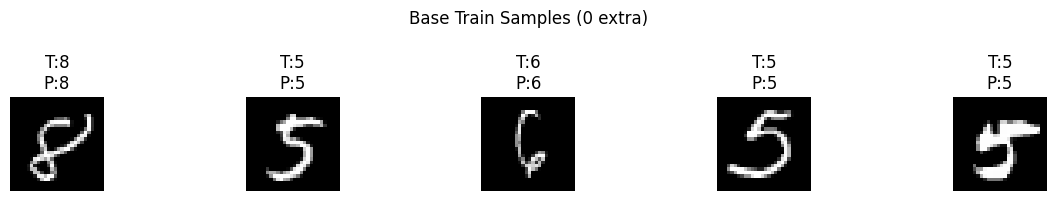

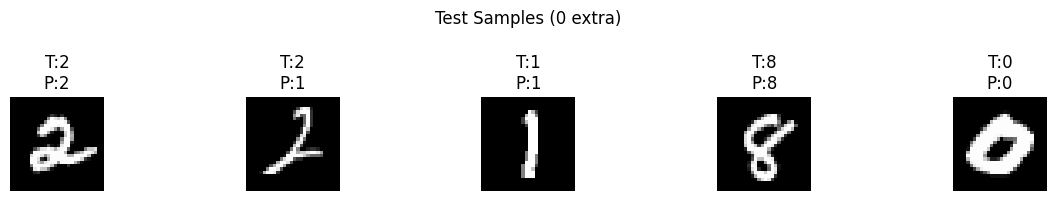

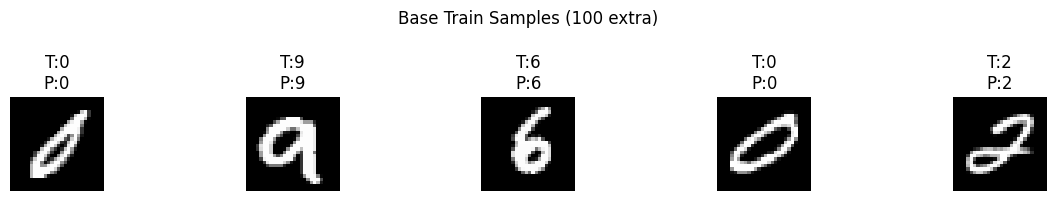

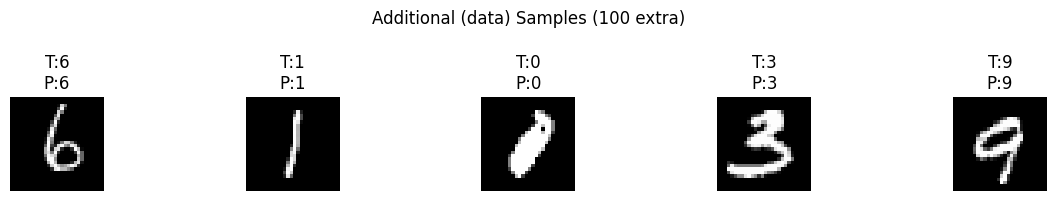

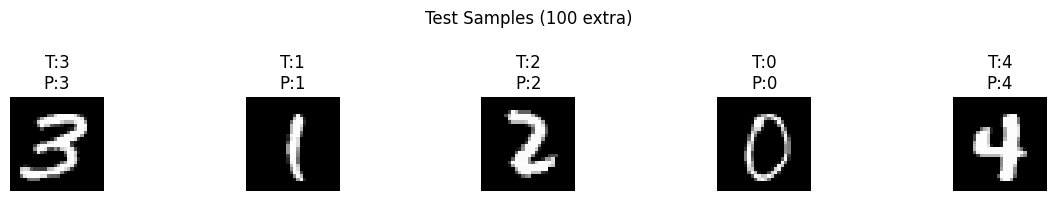

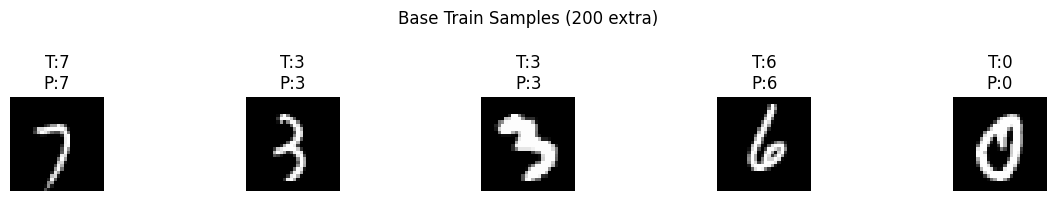

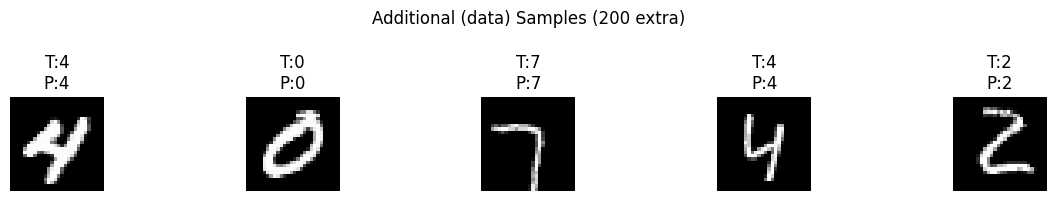

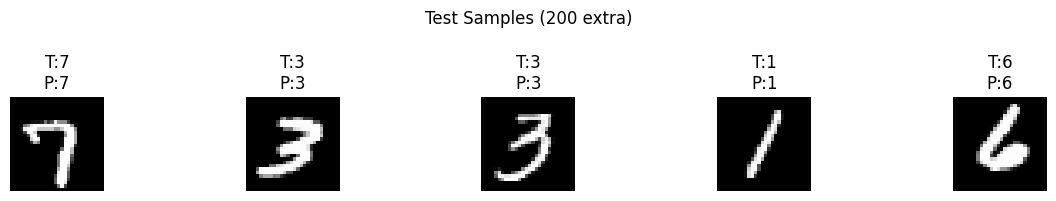

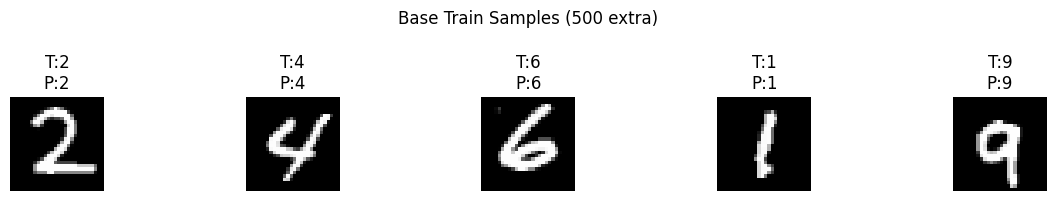

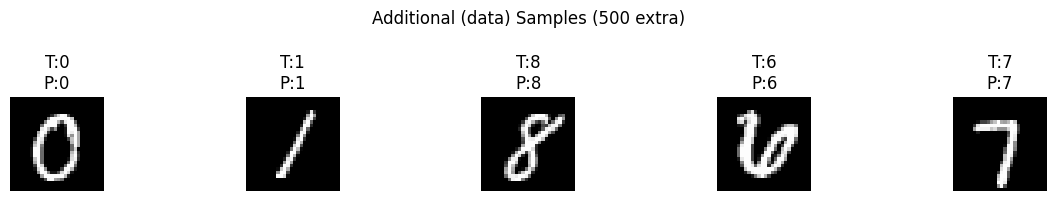

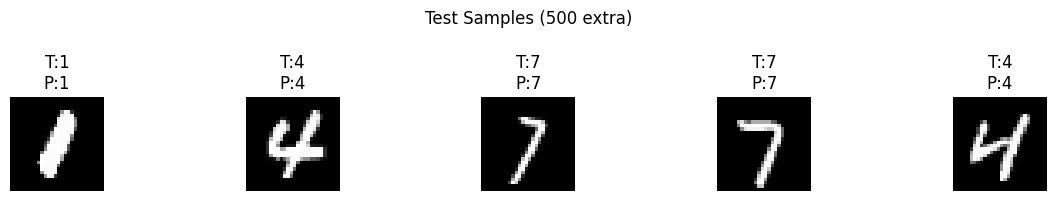

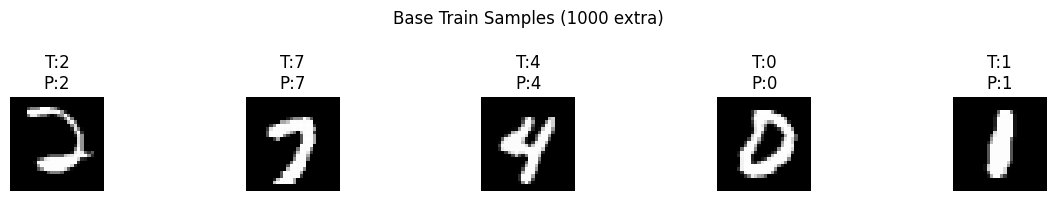

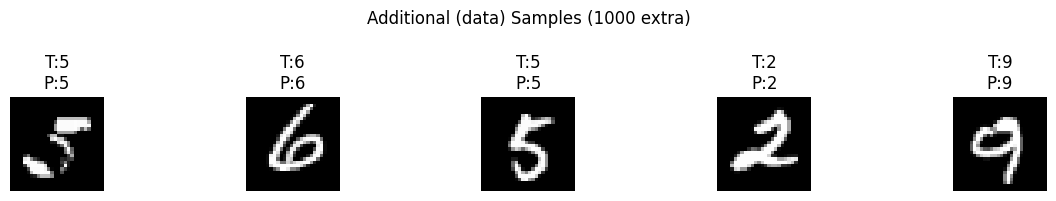

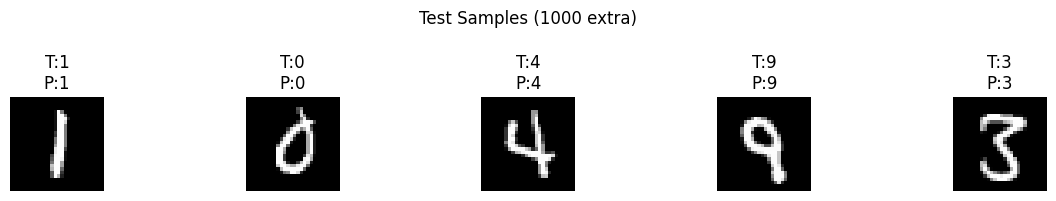

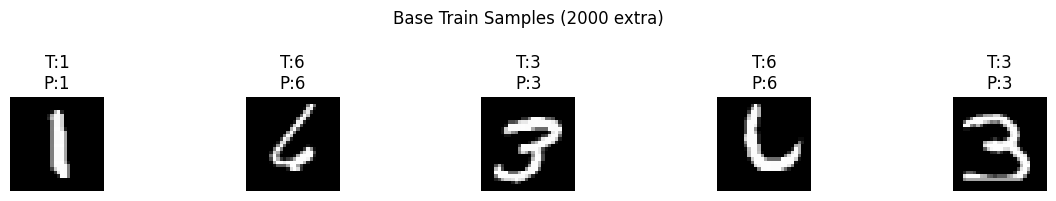

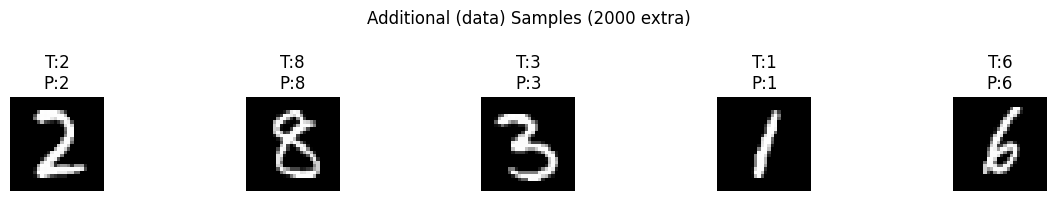

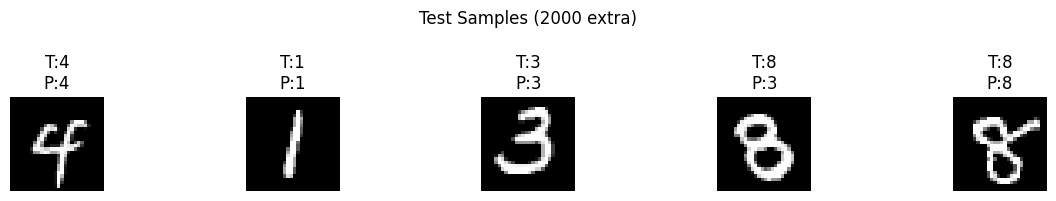

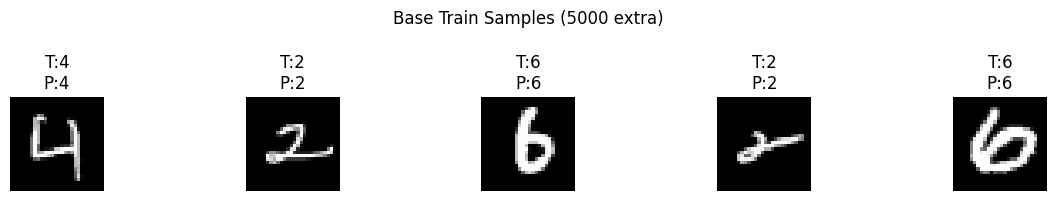

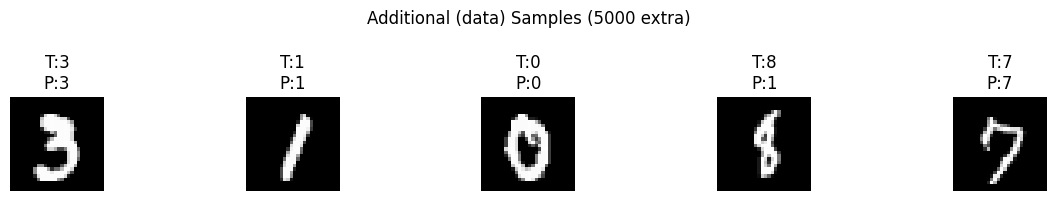

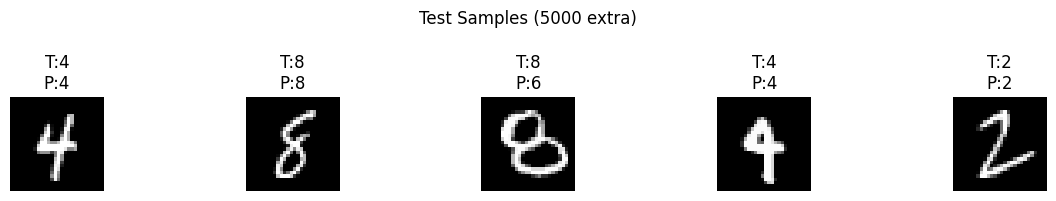

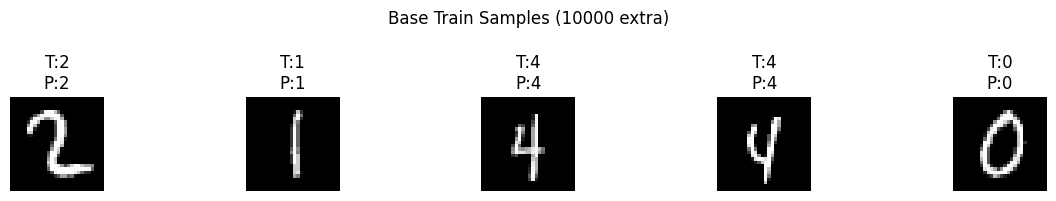

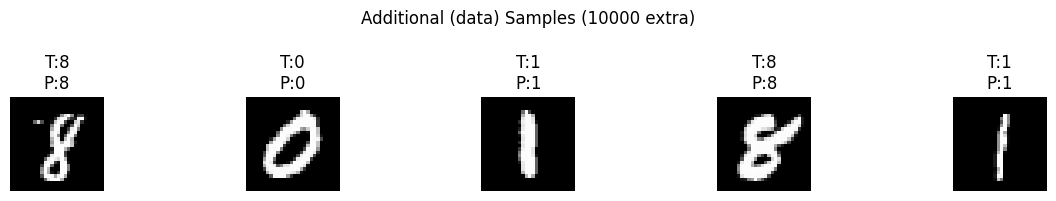

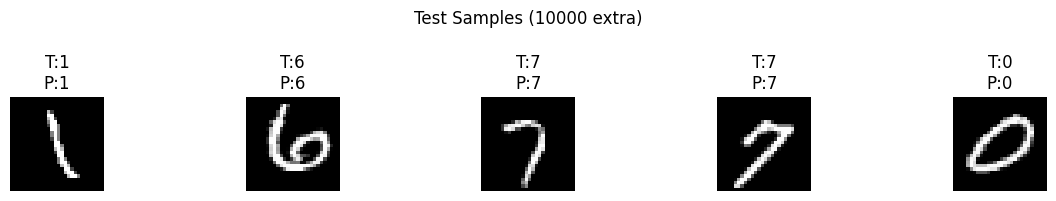

In [6]:
model_module.verify_model_results(
    all_models=all_models,
    x_base_train=x_base_train,
    y_base_train=y_base_train,
    x_additional=x_additional,
    y_additional=y_additional,
    x_test=x_test,
    y_test=y_test,
    dataset_quantities=dataset_quantities,
    dataset_type=dataset_type,
)

## Model Saving

In [7]:
# ====================================
# Save Datasets and Models
# ====================================
output_folder = "models_and_data"
# Save dataset (Possible to skip)
if save_generated_dataset:
    save_dataset(
        folder=output_folder,
        filename="dataset.pt",
        x_base_train=x_base_train,
        y_base_train=y_base_train,
        x_additional=x_additional,
        y_additional=y_additional,
        x_test=x_test,
        y_test=y_test,
        dataset_quantities=dataset_quantities,
        dataset_type=dataset_type,
    )
    print(f"Saved dataset to {output_folder}/dataset.pt")

# Save trained models
if save_generated_models:
    for model_data in all_models:
        filename = f"model_additional_{model_data['additional_data']}.pt"
        save_model(
            folder=output_folder,
            filename=filename,
            model=model_data["model"],
            train_loss=model_data["train_loss"],
            train_accs=model_data["train_accs"],
            test_loss=model_data["test_loss"],
            test_accs=model_data["test_accs"],
            additional_data=model_data["additional_data"],
            dataset_type=model_data["dataset_type"],
        )
        print(f"Saved model: {output_folder}/{filename}")

✅ Dataset saved to models_and_data/dataset.pt
Saved dataset to models_and_data/dataset.pt
✅ Model saved to models_and_data/model_additional_0.pt
Saved model: models_and_data/model_additional_0.pt
✅ Model saved to models_and_data/model_additional_100.pt
Saved model: models_and_data/model_additional_100.pt
✅ Model saved to models_and_data/model_additional_200.pt
Saved model: models_and_data/model_additional_200.pt
✅ Model saved to models_and_data/model_additional_500.pt
Saved model: models_and_data/model_additional_500.pt
✅ Model saved to models_and_data/model_additional_1000.pt
Saved model: models_and_data/model_additional_1000.pt
✅ Model saved to models_and_data/model_additional_2000.pt
Saved model: models_and_data/model_additional_2000.pt
✅ Model saved to models_and_data/model_additional_5000.pt
Saved model: models_and_data/model_additional_5000.pt
✅ Model saved to models_and_data/model_additional_10000.pt
Saved model: models_and_data/model_additional_10000.pt
